In [1]:
%run notebook_importer.ipynb

In [2]:
import resource_cpu
import resource_disktape
import CostEvolution

def run_computing_model(model):
    processing_times=resource_cpu.software_performance(model)
    events,cpu_time,cpu_required=resource_cpu.compute_cpu_needs(model,processing_times)
    resource_cpu.add_analysis_model(model,events,cpu_time,cpu_required)
    resource_cpu.shutdown_year_model(model,processing_times,events,cpu_time,cpu_required)
    #total_cpu_required, total_cpu_time, hpc_cpu_required, hpc_cpu_time = 
    resource_cpu.compute_totals(model,cpu_time,cpu_required)
    cpu_capacity,cpu_time_capacity,cpuCapacity,cpuTimeCapacity=resource_cpu.compute_cpu_capacity(model)

    diskAdded,tapeAdded,diskCapacity,tapeCapacity = resource_disktape.build_storage_capacity_model(model)
    dataProduced,producedByTier = resource_disktape.compute_storage_needs(model)
    diskByYear,tapeByYear,dataOnDisk,dataOnTape,diskSamples,tapeSamples,copies_on_disk,tiers_on_disk = resource_disktape.compute_annual_storage(model,dataProduced, producedByTier,diskCapacity,tapeCapacity)
    diskByTier,tapeByTier = resource_disktape.create_storage_dataframes(model,dataOnDisk,dataOnTape,diskByYear,tapeByYear,diskCapacity,tapeCapacity)
    resource_disktape.add_legacy_disk(model,diskByTier,diskByYear)
    storage_totals=resource_disktape.compute_storage_totals(model,diskByTier,tapeByTier,copies_on_disk,tiers_on_disk)

    import numpy
    needed_resources={}
    YEARS = numpy.arange(model['start_year'], model['end_year']+1)
    needed_resources['cpu'] = numpy.array( [cpu_time['total'][y]  for y in YEARS] ) / ( 365.*24.*3600)
    needed_resources['disk'] = storage_totals['disk']
    needed_resources['tape'] = storage_totals['tape']

    costPerYear=CostEvolution.computeCosts(YEARS,model['cost_model'], needed_resources)

    costMetric = costPerYear['cpu'][2025-YEARS[0]] + costPerYear['cpu'][2026-YEARS[0]]  
    costMetric = costMetric + costPerYear['cpu'][2027-YEARS[0]] + costPerYear['disk'][2025-YEARS[0]] 
    costMetric = costMetric + costPerYear['disk'][2026-YEARS[0]] + costPerYear['disk'][2027-YEARS[0]] 
    costMetric = costMetric + costPerYear['tape'][2025-YEARS[0]] + costPerYear['tape'][2026-YEARS[0]]
    costMetric = costMetric + costPerYear['tape'][2027-YEARS[0]]

    cpuMetric = needed_resources['cpu'][2025-YEARS[0]] + needed_resources['cpu'][2026-YEARS[0]] + needed_resources['cpu'][2027-YEARS[0]]
    
    details= {'cpu_time' : cpu_time,
              'cpu_required' : cpu_required,
              'cpu_capacity' : cpu_capacity,
              'cpu_time_capacity' : cpu_time_capacity,
              'cpuCapacity' : cpuCapacity,
              'cpuTimeCapacity' : cpuTimeCapacity,
              'producedByTier' : producedByTier,
              'diskByTier' : diskByTier,
              'tapeByTier' : tapeByTier,
              'diskByYear' : diskByYear,
              'tapeByYear' : tapeByYear,
              'diskSamples' : diskSamples,
              'tapeSamples' : tapeSamples,
              'copies_on_disk' : copies_on_disk,
              'tiers_on_disk' : tiers_on_disk,
              'YEARS' : YEARS,
              'dataProduced' : dataProduced,
              'needed_resources' : needed_resources,
              'costPerYear' : costPerYear
             }
    metrics={'cost': costMetric, 'hllhc_cpuhs06s': cpuMetric}
    return metrics,details
    
#print costMetric

importing Jupyter notebook from resource_cpu.ipynb
importing Jupyter notebook from resource_utils.ipynb
importing Jupyter notebook from resource_disktape.ipynb
importing Jupyter notebook from resource_plots.ipynb
importing Jupyter notebook from CostEvolution.ipynb


In [3]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = 10, 6



import resource_cpu
import resource_disktape
import CostEvolution

jsons=['json/RelyOnMiniAOD.json', 'json/Analysis.json', 'json/2018changes.json', 'json/2018FallChanges.json', 
       'json/IntroduceNanoAOD.json'] 
model=resource_cpu.create_model(jsons )
model['names']=jsons

cost_models=CostEvolution.define_cost_model()

model['cost_model']=cost_models

metrics,details=run_computing_model(model)

{u'2050': 1.0, u'2026': 1.0, u'2016': 1.0, u'2021': 1.0}
(1.0, 2016)
('Prompt fraction', {2016: 1.0, 2017: 1.0, 2018: 1.0, 2019: 1.0, 2020: 1.0, 2021: 1.0, 2022: 1.0, 2023: 1.0, 2024: 1.0, 2025: 1.0, 2026: 1.0, 2027: 1.0})


In [4]:
resource_cpu.print_cpu_results(model,details['cpu_time'],details['cpu_required'],
                  details['cpu_capacity'],details['cpu_time_capacity'],
                  details['cpuCapacity'],details['cpuTimeCapacity'])
resource_cpu.print_cpu_info(model,details['cpu_time'])

CPU requirements in HS06
Year Prompt NonPrompt LHCMC HLLHCMC Ana Total Cap1 Cap2 Ratio USCMS HPC
2016 0.441 0.295 0.829 0.100 0.071 1.735 1.603 1.630 MHS06 1.065 0.694 0.705
2017 0.441 0.295 0.829 0.122 0.222 1.909 1.823 1.634 MHS06 1.168 0.764 0.653
2018 0.441 0.295 0.829 0.144 0.374 2.082 2.061 1.671 MHS06 1.246 0.833 0.609
2019 0.000 0.198 1.130 0.151 0.501 1.981 2.321 1.744 MHS06 1.136 0.792 0.747
2020 0.000 0.000 0.342 0.156 0.498 0.997 3.004 2.218 MHS06 0.449 0.399 0.500
2021 0.488 0.326 0.466 0.158 0.532 1.969 3.732 2.772 MHS06 0.710 0.788 0.482
2022 0.443 0.296 0.423 0.159 0.228 1.550 4.512 3.410 MHS06 0.455 0.620 0.567
2023 0.403 0.269 0.385 0.158 0.372 1.587 5.349 4.112 MHS06 0.386 0.635 0.512
2024 0.000 0.091 0.525 0.156 0.500 1.272 6.251 4.884 MHS06 0.260 0.509 0.607
2025 0.000 0.091 0.525 4.742 0.754 6.112 7.225 5.372 MHS06 1.138 2.445 0.877
2026 19.984 13.364 0.022 17.245 1.936 52.552 8.278 5.910 MHS06 8.892 21.021 0.583
2027 44.874 30.008 0.000 19.362 4.367 98.611 9.420 

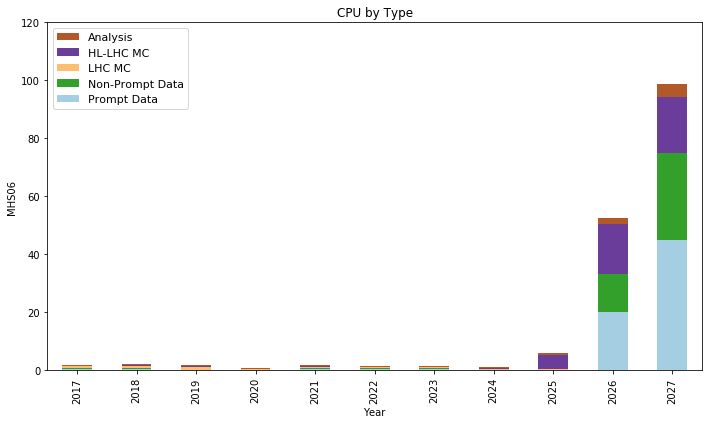

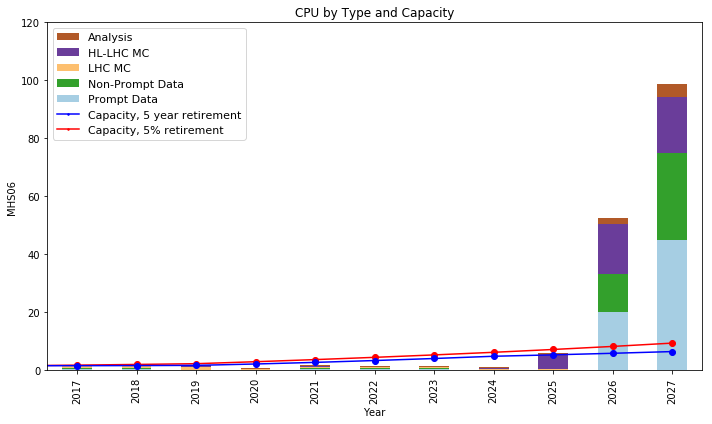

In [5]:
resource_cpu.plot_hs06(model,details['cpu_required'],details['cpu_capacity'],details['cpuCapacity'])

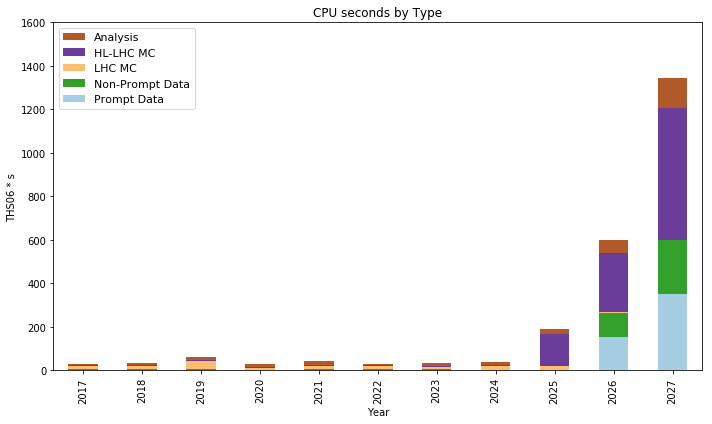

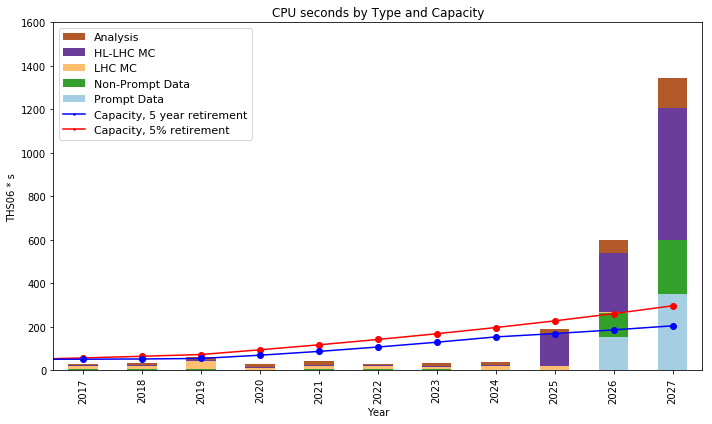

In [6]:
resource_cpu.plot_cpu_hs06s(model,details['cpu_time'],details['cpu_time_capacity'],details['cpuTimeCapacity'])


min Year 0.5


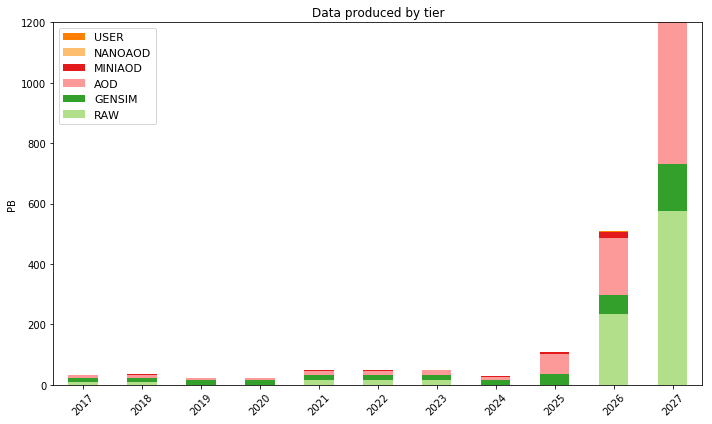

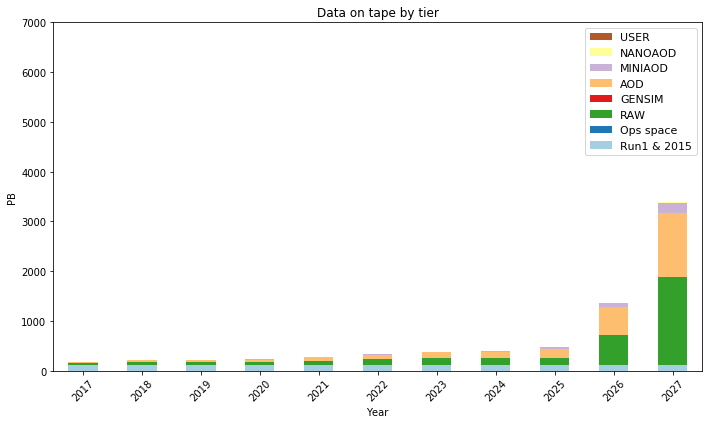

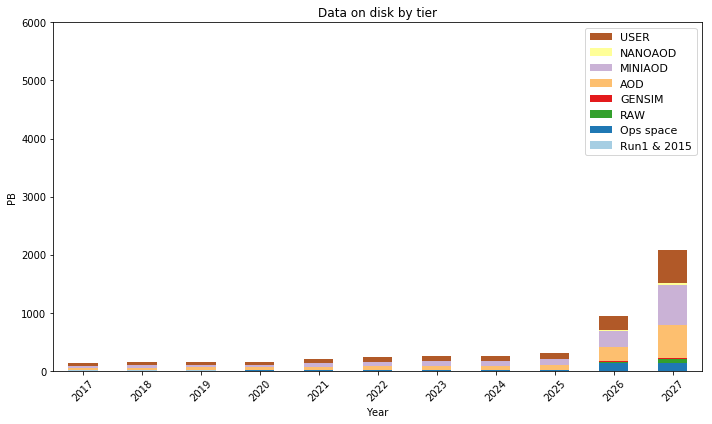

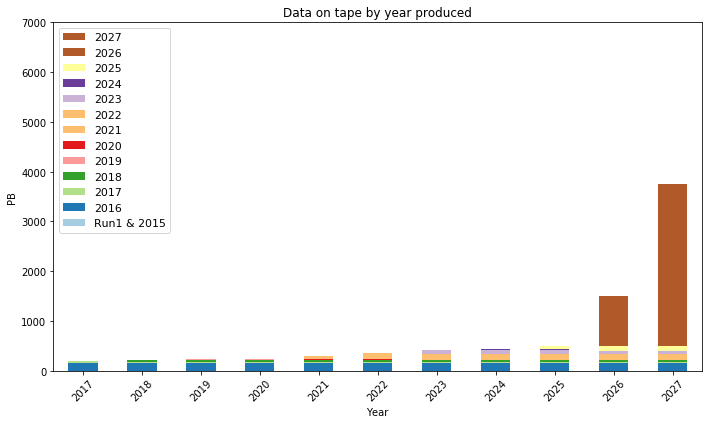

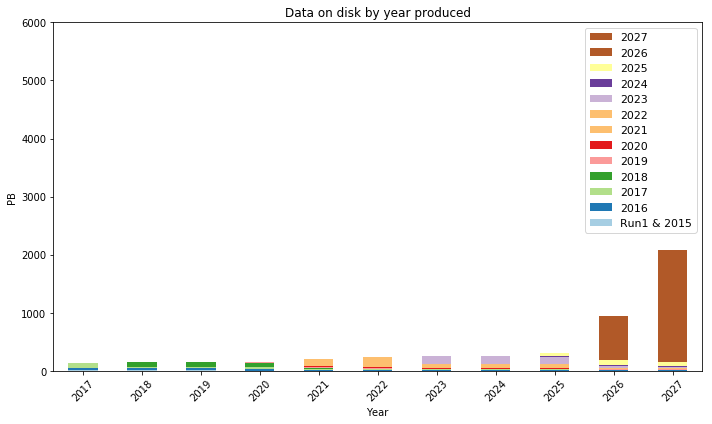

In [7]:

resource_disktape.storage_plots(model,details['producedByTier'],details['diskByTier'],
              details['tapeByTier'],details['diskByYear'],details['tapeByYear'])


In [8]:
resource_disktape.storage_table(model,details['producedByTier'],details['diskByTier'],details['tapeByTier'],
              details['diskByYear'],details['tapeByYear'],details['diskSamples'],
              details['tapeSamples'],details['copies_on_disk'],details['tiers_on_disk'])


Disk by tier printout in PB

year;AOD;MINIAOD;NANOAOD;RAW;USER;GENSIM;Ops space;Run1 & 2015;total;40%
2016    18.47    20.78     0.00     0.93    40.10     1.80    13.00    10.00  105.07   42.03
2017    26.84    32.64     0.00     0.93    47.10     1.81    13.00     5.00  127.32   50.93
2018    35.33    44.69     0.00     0.93    49.71     1.82    13.00     5.00  150.47   60.19
2019    37.01    46.37     0.00     0.93    51.25     1.82    13.00     5.00  155.37   62.15
2020    41.29    50.65     0.00     0.93    51.44     1.82    13.00     0.00  159.11   63.65
2021    52.68    59.60     0.00     1.85    73.99     1.84    13.00     0.00  202.97   81.19
2022    60.93    69.97     0.00     1.85    81.37     1.85    13.00     0.00  228.98   91.59
2023    70.34    81.49     0.00     1.85    85.14     1.86    13.00     0.00  253.68  101.47
2024    73.04    84.05     0.00     1.85    87.47     1.86    13.00     0.00  261.28  104.51
2025    89.94   100.91     0.48     1.85    92.73     1.86  

Year    kHS06  PBDisk  PBTape   Cost   Cost   Cost
2016    771.5   105.1   159.0   10.8   14.8    2.0
2017    945.0   127.3   186.6    2.9    3.7    0.5
2018   1118.5   150.5   214.3    2.5    3.3    0.4
2019   1980.7   155.4   222.1    7.9    1.4    0.2
2020    996.7   159.1   230.0    0.0    1.1    0.2
2021   1361.9   203.0   285.0    2.8    3.5    0.4
2022    998.0   229.0   334.7    2.7    7.8    1.1
2023   1085.3   253.7   384.6    1.6    2.8    0.4
2024   1272.1   261.3   397.0    1.8    1.8    0.2
2025   6111.8   300.8   469.3   20.8    2.0    0.3
2026  19024.8   943.8  1362.5   40.4   20.6    2.6
2027  42689.0  2071.8  3388.1   65.6   32.2    5.2


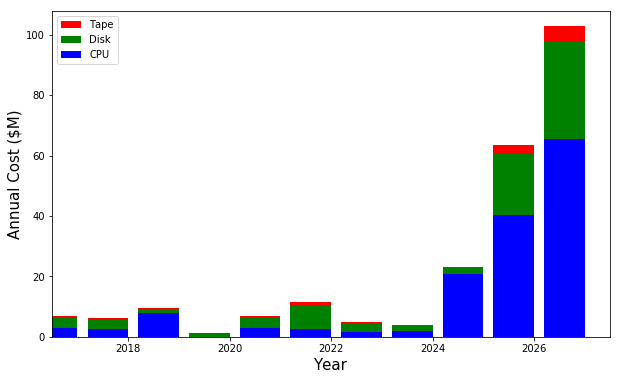

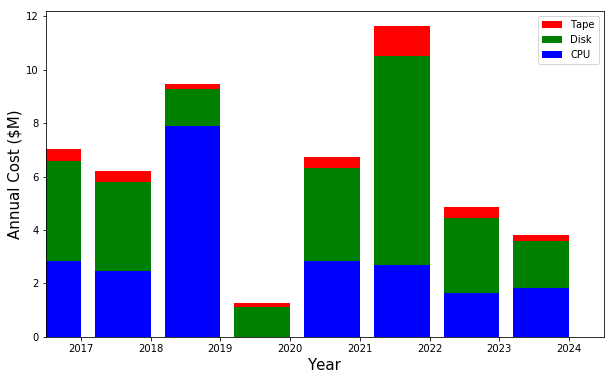

In [9]:
#example, these are TH06*seconds - roughtly taken from May exercise
import numpy

CostEvolution.printCosts(details['YEARS'],details['needed_resources'],details['costPerYear'])

CostEvolution.plotCosts(1,details['YEARS'],[details['costPerYear']['cpu'],details['costPerYear']['disk'],
                              details['costPerYear']['tape']],['CPU','Disk','Tape'])

CostEvolution.plotCosts(2,details['YEARS'][:9],[details['costPerYear']['cpu'][:9],details['costPerYear']['disk'][:9],
                                  details['costPerYear']['tape'][:9]], ['CPU','Disk','Tape'])

